In [1]:
import pandas as pd
import numpy as np
import glob
import os
import time

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import matplotlib.dates as mdates
import folium
from folium import plugins
import h3
import geopy.distance

import plotly
import plotly.express as px
import plotly.figure_factory as ff

from geojson import Feature, FeatureCollection
import geojson
import json
import matplotlib

import datetime
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

import geopandas as gpd
import json
import requests
from shapely.geometry import Polygon, LineString, MultiLineString, Point
import shapely.ops as ops
from pyproj import Geod

import uuid
import hashlib

import warnings
warnings.filterwarnings('ignore')

map_center = [51.49856419519174, -2.548053188420676]
bus_list = ['70', '72', '74', 'm1', 'm3', 'm4']
hex_res = 11
bus_speed_limit = 48
unique_idetifier_cols = ['LineRef',  'DirectionRef', 'VehicleRef', 'BlockRef', 'DatedVehicleJourneyRef', 'OriginAimedDepartureTime', 'DestinationAimedArrivalTime']
geod = Geod(ellps="WGS84")

dir_path = '../data/raw/recorded'
trip_path = '../data/processed/trips/'
base_path = '../data/processed/trips_matched/'
# core_data_path = '../data/processed/core_data.csv'
# log_files_path = '../data/processed/core_data_processed_files.csv'
trip_pkl_files = sorted(glob.glob(os.path.join(trip_path, '*.pkl')))
matched_trip_pkl_files = sorted(glob.glob(os.path.join(base_path, '*.pkl')))
std_col_list = ['RecordedAtTime','ItemIdentifier','ValidUntilTime','LineRef','DirectionRef','DataFrameRef','DatedVehicleJourneyRef','PublishedLineName','OperatorRef','OriginRef','OriginName','DestinationRef','DestinationName','OriginAimedDepartureTime','DestinationAimedArrivalTime','Longitude','Latitude','LongitudeMatched','LatitudeMatched','BlockRef','VehicleRef','TicketMachineServiceCode','JourneyCode','VehicleUniqueId','TripId', 'EstimatedRoute']
siri_id_cols = ['LineRef', 'DirectionRef', 'DatedVehicleJourneyRef', 'BlockRef']
service_lookup_id_cols = ['LineName', 'Direction', 'JourneyCode', 'BlockNumber']

# bristol_temple_meads = Point(51.449574343740345, -2.580549737314868)
# bristol_parkway = Point(51.514414056761495, -2.54327060775988)
# bristol_broadquay = Point(51.45319747495111, -2.5971874688706373)

bristol_temple_meads = Point(-2.580549737314868, 51.449574343740345)
bristol_parkway = Point(-2.54327060775988, 51.514414056761495)
bristol_broadquay = Point(-2.5971874688706373, 51.45319747495111)
uwe_coor= Point(-2.5461254700104576, 51.49989442322204)

In [5]:
# Load master data
master_dir = '../data/processed/timetable/'
service_lookup_table = pd.read_pickle(master_dir+'master_service_lookup_table.pkl')
tracking_data = pd.read_pickle(master_dir+'master_tracking_data.pkl')
timing_data = pd.read_pickle(master_dir+'master_timing_data.pkl')
stop_info = pd.read_pickle(master_dir+'master_stop_info.pkl')

siri_id_cols = ['LineRef', 'DirectionRef', 'DatedVehicleJourneyRef', 'BlockRef']
service_lookup_id_cols = ['LineName', 'Direction', 'JourneyCode', 'BlockNumber']

# service_lookup_table['JourneyCode'] = service_lookup_table['JourneyCode'].astype(int)
# service_lookup_table['BlockNumber'] = service_lookup_table['BlockNumber'].astype(int)
# for col in service_lookup_id_cols:
#     service_lookup_table[col] = service_lookup_table[col].astype(str)

# Functions

In [2]:
def df_insert_row(original_df, row_dictionary):
    # Convert row dictionary to DataFrame
    row_df = pd.DataFrame([row_dictionary])
    # Concatenate the original_df with the new row_df
    updated_df = pd.concat([original_df, row_df], ignore_index=True)
    return updated_df

def linestring_to_string(line):
    # Extract the coordinates from the LineString and format them
    coords = list(line.coords)
    coords_str = ','.join(f'({x},{y})' for x, y in coords)
    linestring_str = f'LineString([{coords_str}])'
    return linestring_str

def linestring_length(line):
    '''
    enter a Linestring,
    returns line length
    '''
    geod = Geod(ellps="WGS84")
    return geod.geometry_length(line)

def p2p_distance(line, point1, point2):
    '''
    enter a Linestring, and 2 Point shapely object
    returns the distance of two points on the line
    '''
    # Project the points onto the LineString to get distances along the LineString
    proj1 = line.project(point1, normalized=True)
    proj2 = line.project(point2, normalized=True)
    
    # Ensure proj1 is less than proj2 for correct segment extraction
    start_proj, end_proj = sorted([proj1, proj2])
    
    # line_gpd = gpd.GeoDataFrame(geometry=[line], crs=4326)
    geod = Geod(ellps="WGS84")
    line_length = geod.geometry_length(line)
    
    return (end_proj-start_proj)*line_length

def is_points_follow_line(line, point1, point2):
    '''
    enter a Linestring, and 2 Point shapely object
    returns True if point1 goes to point2 according to the line direction or point1=point2,
    returns False if point2 goes to point1 according to the line direction

    '''
    # Project the points onto the LineString to get distances along the LineString
    proj1 = line.project(point1, normalized=True)
    proj2 = line.project(point2, normalized=True)
    
    return True if proj1<=proj2 else False

# Decode an encoded string
def decode(encoded):
  inv = 1.0 / 1e6
  decoded = []
  previous = [0,0]
  i = 0
  # For each byte
  while i < len(encoded):
    # For each coord (lat, lon)
    ll = [0,0]
    for j in [0, 1]:
      shift = 0
      byte = 0x20
      # Keep decoding bytes until you have this coord
      while byte >= 0x20:
        byte = ord(encoded[i]) - 63
        i += 1
        ll[j] |= (byte & 0x1f) << shift
        shift += 5
      # Get the final value adding the previous offset and remember it for the next
      ll[j] = previous[j] + (~(ll[j] >> 1) if ll[j] & 1 else (ll[j] >> 1))
      previous[j] = ll[j]
    # Scale by the precision and chop off long coords also flip the positions so
    # Iits the far more standard lon,lat instead of lat,lon
    decoded.append([float('%.6f' % (ll[1] * inv)), float('%.6f' % (ll[0] * inv))])
  # Return the list of coordinates
  return decoded

def map_matching(data, lon_col_name='Longitude', lat_col_name='Latitude', time_col_name='RecordedAtTime',
                 search_radius=5, costing='bus', turn_penalty_factor=100):
    '''
    data: a dataframe containing lon, lat and time (seconds)

    return two results:
        a linestring for estimated route
        a DataFrame contains matched data on the exact order of input data
    '''
    data = pd.DataFrame({
        'lon': data[lon_col_name],
        'lat': data[lat_col_name],
        'time': data[time_col_name].apply(lambda x: x.timestamp())
    }).reset_index(drop=True)

    meili_coordinates = data.to_json(orient='records')
    meili_head = '{"shape":'
    meili_tail = f""","search_radius": {search_radius}, "shape_match":"map_snap", "costing":"{costing}", "format":"osrm", "turn_penalty_factor":{turn_penalty_factor}"""+"}"
    meili_request_body = meili_head + meili_coordinates + meili_tail
    # url = "http://localhost:8002/trace_route"
    url = "http://localhost:8002/trace_attributes"
    headers = {'Content-type': 'application/json'}
    request = requests.post(url, data=str(meili_request_body), headers=headers)

        # READ & FORMAT VALHALLA RESPONSE
    if request.status_code == 200:
        response_text = json.loads(request.text)
    else:
        print(f'API Error, {request.status_code}')
        return None, pd.DataFrame()

    matching = dict(response_text).get('shape')

    # lst_MapMatchingRoute = [LineString(decode(matching))]
    # estimated_route = gpd.GeoDataFrame(geometry=lst_MapMatchingRoute, crs=4326)
    lst_MapMatchingRoute = LineString(decode(matching))

    tracepoints = list(response_text.get('matched_points'))
    df_mapmatchedGPS_points = pd.DataFrame([(p['lon'],p['lat']) if (p is not None) else [None,None] for p in tracepoints] , columns=['LongitudeMatched', 'LatitudeMatched']).reset_index(drop=True)

    # result = pd.concat([data, df_mapmatchedGPS_points], axis=1)

    # df_mapmatchedGPS_points = df_mapmatchedGPS_points.loc[
    #     (df_mapmatchedGPS_points['lat'].notnull()) &
    #     (df_mapmatchedGPS_points['lon'].notnull())]
    
    return lst_MapMatchingRoute, df_mapmatchedGPS_points

def clutter_detection(data, w, r):
    '''
    data: a series containing 'lat' and 'lon' sorted in sequential order.
    r: the radius to identify the clutter. r can be estimate using the GPS error radius.

    return the index of the potential clutters
    '''
    core_list = data
    issue_list = []
    for i in range(1,len(core_list)):
        # print(i)
        start = max(0, i-int(w/2))
        stop = min(i+int(w/2), len(core_list)-1)
        if geopy.distance.geodesic(core_list[start], core_list[stop]).meters<r:
            issue_list.append(i)
    return issue_list

def clutter_grouping(data, w, s, record_count=150):
    '''
    data: a series of problematic points
    s: sensitivity determins how wide the gap is to merge two or more together into a bigger clutter
    w: the moving window size

    return a list of the start points and end points of the clutters
    '''
    if len(data)==0:
        return []

    clusters = []
    result = []
    current_group = [data[0]]

    for i in range(1, len(data)):
        # print(i)
        if data[i] - data[i-1] <= s:
            current_group.append(data[i])
        else:
            clusters.append(current_group)
            current_group = [data[i]]

    clusters.append(current_group)

    for j in clusters:
        # print(j)
        result.append([max(j[0]-int(w/2),0),min(j[-1]+int(w/2),record_count)])
    for k in range(0, len(result)-1):
        # print(k)
        if result[k][1]>result[k+1][0]:
            result[k][1] = int((result[k][1]+result[k+1][0])/2)
            result[k+1][0] = result[k][1]
    return result

def decluttering_data(data, w, r, s, lon_col_name='lon', lat_col_name='lat'):
    '''
    data: a Dataframe containing 'lat' and 'lon' sorted in sequential order.
    w: the moving window size
    r: the radius to identify the clutter. r can be estimate using the GPS error radius.
    s: sensitivity determins how wide the gap is to merge two or more together into a bigger clutter

    return the dataset clutters removed
    '''
    data = data.reset_index(drop=True)
    core_list = data[[lon_col_name,lat_col_name]].to_numpy()
    # print(core_list)
    issue_list = clutter_detection(core_list, w, r)
    # print(issue_list)
    clutter_list = clutter_grouping(issue_list, w, s, data.shape[0]-1)
    # print(clutter_list)

    if len(clutter_list) > 0:
        # A list of uncluttered indeces
        index_list = []
        index = 0
        for i in range(0, len(clutter_list)):
            if clutter_list[i][0]<=0:
                clutter_list[i][0]=0
            if clutter_list[i][1]>=len(core_list)-1:
                clutter_list[i][1]=len(core_list)-1
            while index<=clutter_list[i][0]:
                index_list.append(index)
                # print(index_list)
                index+=1
            index=clutter_list[i][1]
            index_list.append(index)
            index+=1
            if i==len(clutter_list)-1:
                while index<=len(core_list)-1:
                    index_list.append(index)  
                    index+=1  
            
        # print(index_list)
        # result_df = data.iloc[index_list]

        return data.iloc[index_list]
    else:
        return data
    
def interpolate_line(line, num_points=100):
    distances = np.linspace(0, line.length, num_points)
    points = [line.interpolate(distance) for distance in distances]
    return LineString(points)


# Map-Matching Trips

In [ ]:
for line_by_date in trip_pkl_files:
    line_data = pd.read_pickle(line_by_date)
    # line_data['OriginAimedDepartureTime'] = pd.to_datetime(line_data['OriginAimedDepartureTime'])
    # line_data['DestinationAimedArrivalTime'] = pd.to_datetime(line_data['DestinationAimedArrivalTime'])
    # line_data['ValidUntilTime'] = pd.to_datetime(line_data['ValidUntilTime'])
    # line_data['RecordedAtTime'] = pd.to_datetime(line_data['RecordedAtTime'])
    # line_data['Longitude'] = pd.to_numeric(line_data['Longitude'])
    # line_data['Latitude'] = pd.to_numeric(line_data['Latitude'])

    for trip in line_data['TripId'].unique().tolist():
        trip_data = line_data[line_data['TripId']==trip].copy().reset_index(drop=True)
        trip_data.sort_values(['RecordedAtTime'], ascending=[True], inplace=True)
        # trip_data = trip_data[trip_data['RecordedAtTime'] >= trip_data['OriginAimedDepartureTime']].copy().reset_index(drop=True)
        print(f'{line_by_date}/{trip}', end='')
        
        # Decluttering trips
        date_string = trip_data['OriginAimedDepartureTime'][0].strftime('%Y%m%d')
        file_link = base_path+'p_'+str(trip_data['LineRef'][0])+'_'+str(date_string)+'.pkl'
        trip_data = decluttering_data(trip_data, w=6, r=50, s=1, lon_col_name='Longitude', lat_col_name='Latitude')
        # Map matching trips
        estimate_route, matched_trip = map_matching(trip_data)
        retry = 0
        while (retry <= 2) and (estimate_route==None):
            time.sleep(0.5)
            estimate_route, matched_trip = map_matching(trip_data)
            retry+=1
        if estimate_route==None:
            estimate_route = LineString([])
        trip_data['EstimatedRoute'] = None
        trip_data['EstimatedRoute'][0] = linestring_to_string(estimate_route)
        
        # Merge new columns to prevous data
        trip_data = pd.concat([trip_data.reset_index(drop=True), matched_trip.reset_index(drop=True)], axis=1)
        
        # Calcuate Distance, Time and Speed
        trip_data['LastTimestamp'] = trip_data['RecordedAtTime'].shift(1)
        trip_data['LastLat'] = trip_data['Latitude'].shift(1)
        trip_data['LastLong'] = trip_data['Longitude'].shift(1)
        trip_data['LastLatMatched'] = trip_data['LatitudeMatched'].shift(1)
        trip_data['LastLongMatched'] = trip_data['LongitudeMatched'].shift(1)
        trip_data['TraveledTime'] = trip_data.apply(lambda x: (x['RecordedAtTime'] - x['LastTimestamp']).total_seconds() if not(pd.isnull(x['LastTimestamp'])) else 0, axis=1)
        
        # Calculate distance based on raw data
        trip_data['TraveledDistanceRaw'] = trip_data.apply(lambda x: geopy.distance.geodesic((x['Latitude'], x['Longitude']), (x['LastLat'], x['LastLong'])).meters if not(pd.isnull(x['LastLat']) or pd.isnull(x['LastLong'])) else 0, axis=1)
        
        # Calculate distance based on mapmatched data
        trip_data['TraveledDistanceMatched'] = trip_data.apply(lambda x: p2p_distance(estimate_route, Point(x['LongitudeMatched'], x['LatitudeMatched']), Point(x['LastLongMatched'], x['LastLatMatched'])) if not(pd.isnull(x['LastLatMatched']) or pd.isnull(x['LastLongMatched'])) else 0, axis=1)

        trip_data['Speed'] = trip_data.apply(lambda x: (x['TraveledDistanceMatched']/1000)/(x['TraveledTime']/60/60) if x['TraveledTime']!=0 else 0, axis=1)
        trip_data['TraveledDistanceMatched'] = trip_data.apply(lambda x: x['TraveledDistanceRaw'] if x['Speed'] > bus_speed_limit*2 else x['TraveledDistanceMatched'], axis=1)
        trip_data['Speed'] = trip_data.apply(lambda x: (x['TraveledDistanceRaw']/1000)/(x['TraveledTime']/60/60) if x['Speed'] > bus_speed_limit*2 else x['Speed'], axis=1)

        # print(journey_data.columns)
        trip_data = trip_data[std_col_list+['LastTimestamp','LastLong','LastLat','LastLongMatched','LastLatMatched','TraveledTime','TraveledDistanceRaw','TraveledDistanceMatched','Speed']]
        if not os.path.exists(base_path):
            print('\tMADE NEW PATH')
            os.makedirs(base_path)
        if os.path.exists(file_link):
            print(f'\tUSE OLD FILE {file_link}')
            buffer_df = pd.read_pickle(file_link)
            buffer_df = pd.concat([buffer_df, trip_data], ignore_index=True).to_pickle(file_link)
            buffer_df = pd.DataFrame()
            # with open(file_link, 'a') as f:
            #     f.write(trip_data.to_csv(index=False, header=False))
            #     f.flush()
        else:
            print('\t\tMADE NEW FILE')
            trip_data.to_pickle(file_link)

# Single Trip Process

In [167]:
# t_line_data = pd.read_csv(matched_trip_csv_files[4])
t_line_data = pd.read_pickle('../data/processed/trips_matched/p_m4_20240719.pkl')
# dt_cols=['RecordedAtTime','ValidUntilTime','OriginAimedDepartureTime','DestinationAimedArrivalTime']
# float_cols=['Longitude','Latitude','LongitudeMatched','LatitudeMatched','TraveledDistanceRaw','TraveledDistanceMatched','Speed']
# int_cols=['LineRef','DatedVehicleJourneyRef','BlockRef','JourneyCode','VehicleUniqueId']
# str_cols=['LineRef','DatedVehicleJourneyRef','BlockRef','EstimatedRoute','TripId']
# for col in dt_cols:
#     t_line_data[col] = pd.to_datetime(t_line_data[col])
# for col in float_cols:
#     t_line_data[col] = t_line_data[col].astype(float)
# for col in int_cols:
#     try:
#         t_line_data[col] = t_line_data[col].astype(int)
#     except:
#         continue
# for col in str_cols:
#     t_line_data[col] = t_line_data[col].astype(str)

t_trips = t_line_data['TripId'].unique().tolist()
# sample_trip = t_line_data[t_line_data['TripId']==t_trips[10]].copy().reset_index(drop=True)
sample_trip = t_line_data[t_line_data['TripId']=='e8018d91-56d6-59ed-908b-e55ec76cdfc7'].copy().reset_index(drop=True)
t_estimated_route = eval(sample_trip['EstimatedRoute'][0])
# sample_trip = sample_trip[sample_trip['RecordedAtTime'] >= sample_trip['OriginAimedDepartureTime']]
sample_trip['TimeCumSum'] = np.cumsum(sample_trip['TraveledTime'])
sample_trip['DistanceCumSum'] = np.cumsum(sample_trip['TraveledDistanceMatched'])

Match with respective "ideal" data

In [168]:
# Calculate Path Properties
is_wrong_time = False
is_diverted = False
is_unplanned = False
trip_type = 'Other'
trip_line_name = sample_trip.iloc[0]['LineRef'] 

t_timetable_data_service = (sample_trip[unique_idetifier_cols+['TripId']]
                    .head(1)
                    .merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', 
                        left_on=siri_id_cols, right_on=service_lookup_id_cols))
t_timetable_data_path = tracking_data.loc[
    (tracking_data['RouteId']==t_timetable_data_service['RouteRef'][0]) &
    (tracking_data['LineRef']==t_timetable_data_service['LineRef'][0])
]
t_timetable_data_time = timing_data.loc[
    (timing_data['JourneyPatternSectionId']==t_timetable_data_service['JourneyPatternSectionRefs'][0]) &
    (timing_data['BlockNumber'].astype(str)==t_timetable_data_service['BlockNumber'].astype(str)[0])
]
t_tracking_data = t_timetable_data_path.merge(t_timetable_data_time, 'left', 
                                            left_on=['RouteLinkRef'], 
                                            right_on=['RouteLinkRef']).fillna(0)

t_tracking_data['TimeCumSum'] = np.cumsum(t_tracking_data['RunTime'])+np.cumsum(t_tracking_data['WaitTime'])
t_tracking_data['DistanceCumSum'] = np.cumsum(t_tracking_data['Distance'])

merged_planned_linestring = []
for segment in t_timetable_data_path['TrackingPoints']:
    merged_planned_linestring = merged_planned_linestring + segment
merged_planned_linestring = LineString(merged_planned_linestring)
actual_linestring = gpd.GeoDataFrame(geometry=[t_estimated_route], crs=4326)
planned_linestring = gpd.GeoDataFrame(geometry=[LineString(segment) for segment in t_timetable_data_path['TrackingPoints']], crs=4326)
raw_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(sample_trip['Longitude'], sample_trip['Latitude']), crs=4326)

# Overrall Matching Statistics
## Resolution is the number of 5m segments in actual trip
resolution = int(geod.geometry_length(actual_linestring['geometry'][0])/5)
actual_linestring_interp = interpolate_line(actual_linestring['geometry'][0], resolution)
distance_matching = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring_interp.coords]
match_percentage = (len([i for i in distance_matching if i <=10]))/resolution
# print(match_percentage)
# print(np.mean(distance_matching))


# Calculate Trip Adjustments
trip_adj = sample_trip[sample_trip['RecordedAtTime'] < sample_trip['OriginAimedDepartureTime']]

## If the actual time is shorter than 10 minutes of the ideal timetable (very early arrival), make distance adjustments:
first_point = sample_trip.iloc[0]
first_500m_point = sample_trip[sample_trip['DistanceCumSum']>=500].iloc[0]
last_point = sample_trip.iloc[-1]
travelled_distance_pre_departure = sum(trip_adj['TraveledDistanceMatched'])
is_correct_direction = is_points_follow_line(merged_planned_linestring,
                                            Point([first_point['LongitudeMatched'], first_point['LatitudeMatched']]),
                                            Point([first_500m_point['LongitudeMatched'], first_500m_point['LatitudeMatched']]))
# Default value
strat_trip_adj_time = (sample_trip['RecordedAtTime'][0] - sample_trip['OriginAimedDepartureTime'][0]).total_seconds()
strat_trip_adj_distance = 0

if (abs(strat_trip_adj_time) > 30*60) and (travelled_distance_pre_departure > 500):
    # Unplanned/Adhoc
    trip_type = 'Unplanned'
    is_unplanned = True
elif is_correct_direction and (trip_adj.shape[0] > 0):
    trip_type = 'Starts Recording Early'
    # If the trip starts before expected time
    # start early --> Readjust distance
    strat_trip_adj_distance = -abs(sum(trip_adj['TraveledDistanceMatched']))
elif is_correct_direction and (trip_adj.shape[0] <= 0):
    trip_type = 'Starts Recording Late'
    # # start late --> Interpolate
    # strat_trip_adj_distance = sum(t_tracking_data["Distance"])*t_estimated_route.project(Point([sample_trip['Longitude'][0],
    #                                                                                             sample_trip['Latitude'][0]]), normalized=True)
    strat_trip_adj_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(Point([sample_trip['Longitude'][0], 
                                                                                                                    sample_trip['Latitude'][0]]), normalized=True)
elif ~is_correct_direction and match_percentage > 0.8:
    trip_type = 'In Unfinished Previous Trip'
    # Still in previous trip
    actual_start_point = t_estimated_route.project(Point([t_timetable_data_path.iloc[0]['TrackingPoints'][0][0],
                                                        t_timetable_data_path.iloc[0]['TrackingPoints'][0][1]]), normalized=True)
    strat_trip_adj_distance = -1*actual_start_point*geod.geometry_length(t_estimated_route)
else:
    trip_type = 'Other'
    # Default
    strat_trip_adj_distance = 0


sample_trip['TimeCumSumAdj'] = sample_trip['TimeCumSum'] + strat_trip_adj_time
sample_trip['DistanceCumSumAdj'] = sample_trip['DistanceCumSum'] + strat_trip_adj_distance

# Trip Metrics

## Trip Time and Distance
planned_time = (sum(t_tracking_data["RunTime"])-sum(t_tracking_data["WaitTime"]))
planned_distance = sum(t_tracking_data["Distance"])
actual_time = sum(sample_trip["TraveledTime"])+strat_trip_adj_time
actual_distance = sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance
if (actual_time < 0) or (actual_distance < 0):
    is_wrong_time=True
    actual_time = sum(sample_trip["TraveledTime"])
    actual_distance = sum(sample_trip["TraveledDistanceMatched"])

## GPS errors
gps_error_points = []
prj_points = []
for index, point in sample_trip.iterrows():
    raw_point = Point([point['Longitude'],point['Latitude']])
    raw_point_projection = merged_planned_linestring.project(raw_point)
    proj_raw_point_to_planned_trip = merged_planned_linestring.interpolate(raw_point_projection, normalized=False)
    distance_to_planned_route = geopy.distance.geodesic(raw_point.coords, proj_raw_point_to_planned_trip.coords).meters
    gps_error_points.append(distance_to_planned_route)
    prj_points.append(proj_raw_point_to_planned_trip)
    # print(f'\t\t{raw_point}:{proj_raw_point_to_planned_trip}-{distance_to_planned_route}')
    # print(row['c1'], row['c2'])
# print(f'Median GPS error: {np.median(gps_error_points)}')

## Diversion Check
distance_matching_diversion_check = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring['geometry'][0].coords]
# diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 100]
diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 50]
diversion_data = []
diversion_count = 0
# diversion_check_df = pd.DataFrame()
if len(diversion_check) > 0:
    actual_segment_count = len(actual_linestring['geometry'][0].coords)
    diversion_group = clutter_grouping(diversion_check,2,int(actual_segment_count*0.01),record_count=len(distance_matching_diversion_check)-1)
    for cluster in diversion_group:
        if cluster[0]!=cluster[1]:
            # print('DIVERSION DETECTED')
            diverted_path = LineString([actual_linestring['geometry'][0].coords[i] for i in range(cluster[0], cluster[1]+1)])
            diverted_path_length = geod.geometry_length(diverted_path)
            diversion_start_point = actual_linestring['geometry'][0].coords[cluster[0]]
            diversion_end_point = actual_linestring['geometry'][0].coords[cluster[1]]
            diversion_cluster = {
                'diverted_path': linestring_to_string(diverted_path),
                'diverted_path_length': diverted_path_length,
                'diversion_start_point': diversion_start_point,
                'diversion_end_point': diversion_end_point
            }
            # diversion_check_df = df_insert_row(diversion_check_df, diversion_cluster)
            if diverted_path_length>400:
                diversion_count+=1
                diversion_data.append(diversion_cluster)

diversion_data = np.nan if diversion_data == [] else diversion_data

## Punctuation
### Interpolate actual data
# actual_distance_interp = np.arange(int(list(sample_trip['DistanceCumSumAdj'])[0]), int(list(sample_trip['DistanceCumSumAdj'])[-1]), 5)
distance_interp = np.arange(max(0, int(list(sample_trip['DistanceCumSumAdj'])[0])), 
                            min(int(list(sample_trip['DistanceCumSumAdj'])[-1]), int(list(t_tracking_data['DistanceCumSum'])[-1])), 5)
if len(distance_interp) > 1:
    actual_time_interp = np.interp(distance_interp, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist())
    planned_time_interp = np.interp(distance_interp, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
    ## Get difference series
    ### Negative is earlier than planned and vice versa
    #### Overall Performance
    time_difference = actual_time_interp - planned_time_interp
    total_deviation = float(sum(time_difference))
    mean_deviation = float(np.mean(time_difference))
    std_deviation = float(np.std(time_difference))
    median_deviation = float(np.median(time_difference))
    max_deviation = float(max(time_difference))
    min_deviation = float(min(time_difference))
    deviation_per_km = float(sum(time_difference))/planned_distance
    #### Punctuation Performance
    percentage_ontime = sum((t <= 5*60) and (t >= -1*60) for t in time_difference)/len(time_difference)
    percentage_late = sum((t > 5*60)for t in time_difference)/len(time_difference)
    percentage_early = sum((t < -1*60) for t in time_difference)/len(time_difference)
    segment_sample_size = len(time_difference)
else:
    time_difference = np.nan
    total_deviation = np.nan
    mean_deviation = np.nan
    std_deviation = np.nan
    median_deviation = np.nan
    max_deviation = np.nan
    min_deviation = np.nan
    deviation_per_km = np.nan
    #### Punctuation Performance
    percentage_ontime = np.nan
    percentage_late = np.nan
    percentage_early = np.nan
    segment_sample_size = len(distance_interp)


btm_distance = np.nan
bp_distance = np.nan
bcc_distance = np.nan
btm_time_diff = np.nan
bp_time_diff = np.nan
bcc_time_diff = np.nan

if len(distance_interp) > 1:
    if trip_line_name in ['74','72']:
        btm_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_temple_meads, normalized=True)
        btm_distance_mapping = min(btm_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
        btm_time_diff = np.interp(btm_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(btm_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
    if trip_line_name in ['m4']:
        bp_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_parkway, normalized=True)
        bp_distance_mapping = min(bp_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
        bp_time_diff = np.interp(bp_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bp_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
    if trip_line_name in ['70','72','74','m1','m3','m4']:
        bcc_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_broadquay, normalized=True)
        bcc_distance_mapping = min(bcc_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
        bcc_time_diff = np.interp(bcc_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bcc_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
    

# print(prj_points)
raw_projected_points = gpd.GeoDataFrame(geometry=prj_points, crs=4326)

# fig = px.line(sample_trip, x=sample_trip['TimeCumSumAdj'], y=sample_trip['DistanceCumSumAdj'])
# fig.add_scatter(x=t_tracking_data['TimeCumSum'], y=t_tracking_data['DistanceCumSum'])
# fig.show()

uwe_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(uwe_coor, normalized=True)
uwe_distance_mapping = min(uwe_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
uwe_time_diff = np.interp(uwe_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(uwe_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())


In [143]:
bp_distance

11980.534272608606

In [144]:
uwe_distance

8049.185441388327

In [103]:
trip_type

'Unplanned'

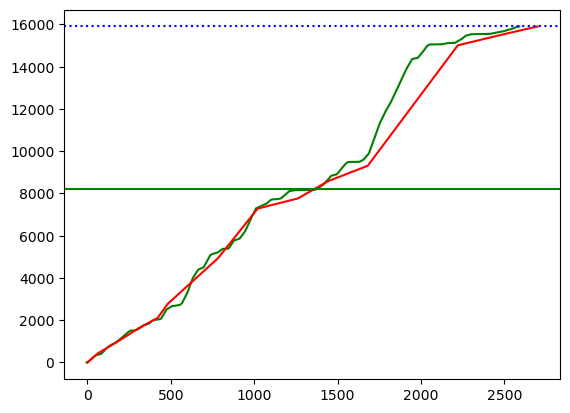

time adj -202.0
distance adj -38.511443820039766


In [165]:
plt.plot(actual_time_interp, distance_interp, color='green')
plt.plot(planned_time_interp, distance_interp, color='red')
plt.axhline(y = uwe_distance, color = 'green')
plt.axhline(y = bcc_distance, color = 'blue', linestyle = 'dotted')
plt.axhline(y = btm_distance, color = 'orange', linestyle = 'dotted')
plt.axhline(y = bp_distance, color = 'purple', linestyle = 'dotted')
# plt.axhline(y = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(uwe_coor, normalized=True), color = 'orange', linestyle = 'dotted')
# plt.plot(time_difference, distance_interp, color='blue')
plt.show()
print(f'time adj {strat_trip_adj_time}')
print(f'distance adj {strat_trip_adj_distance}')

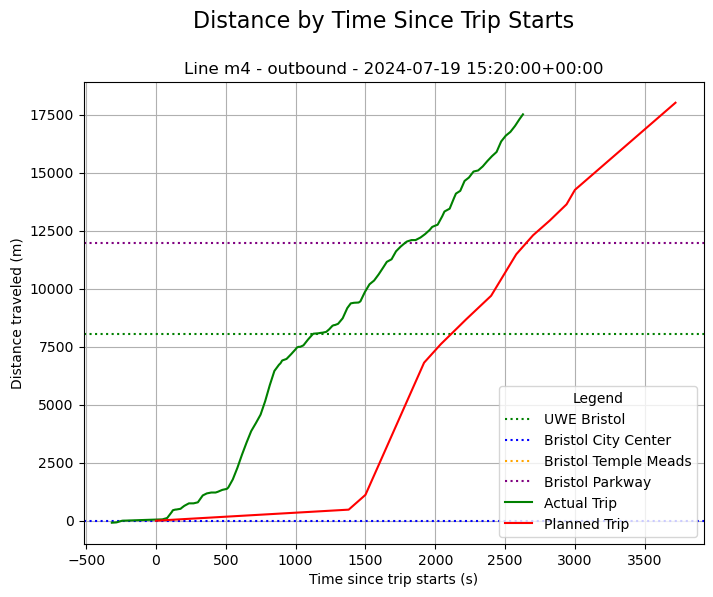

In [169]:
# fig,ax = plt.subplots(1)
plt.figure(figsize=(8, 6))

plt.suptitle('Distance by Time Since Trip Starts', fontsize=16, y=1)
plt.title(f'Line {sample_trip.iloc[0]["LineRef"]} - {sample_trip.iloc[0]["DirectionRef"]} - {sample_trip.iloc[0]["OriginAimedDepartureTime"]}')
plt.grid(True)
plt.xlabel('Time since trip starts (s)')
plt.ylabel('Distance traveled (m)')

plt.axhline(y = uwe_distance, color = 'green', linestyle = 'dotted', label='UWE Bristol')
plt.axhline(y = bcc_distance, color = 'blue', linestyle = 'dotted', label='Bristol City Center')
plt.axhline(y = btm_distance, color = 'orange', linestyle = 'dotted', label='Bristol Temple Meads')
plt.axhline(y = bp_distance, color = 'purple', linestyle = 'dotted', label='Bristol Parkway')

# plt.plot(actual_time_interp, distance_interp, color='green',  label='Actual Trip')
# plt.plot(planned_time_interp, distance_interp, color='red',  label='Planned Trip')
plt.plot('TimeCumSumAdj', 'DistanceCumSumAdj', data=sample_trip, linestyle='-', color='green', label='Actual Trip')
plt.plot([0]+t_tracking_data['TimeCumSum'].tolist(), [0]+t_tracking_data['DistanceCumSum'].tolist(), linestyle='-', color='red', label='Planned Trip')

plt.legend(title='Legend',
           loc=4)

plt.show()

In [ ]:
hausdorff_dist = planned_linestring.to_crs(4326,'WGS84').hausdorff_distance(actual_linestring.to_crs(4326,'WGS84'))
print(hausdorff_dist[0])

In [159]:
print(f'Line {sample_trip.iloc[0]["LineRef"]} - {sample_trip.iloc[0]["DirectionRef"]} - {sample_trip.iloc[0]["OriginAimedDepartureTime"]}')
print(f'Planned Path Distance: {sum(t_tracking_data["Distance"])}')
print(f'Planned Path Time: {planned_time}')
print(f'Actual Path Distance: {sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance}')
print(f'Actual Path Time: {actual_time}')

#%% RAW & MAP-MATCHING ROUTES - DRAW MAP
f = folium.Figure(800, 800)
m = folium.Map([51.49856419519174, -2.548053188420676], tiles='cartodbdark_matter', zoom_start=14).add_to(f)
# m = folium.Map([51.49856419519174, -2.548053188420676], tiles='OpenStreetMap', zoom_start=14)
# folium.GeoJson(before_all, style_function=lambda x:{'color': 'red'}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='red', fill_opacity=1), name='rawGPS_points').add_to(m)
# folium.GeoJson(after_points, marker=folium.CircleMarker(radius=4, weight=0, fill_color='white', fill_opacity=1), name='snapped_points').add_to(m)
# folium.GeoJson(estimated_route, style_function=lambda x:{'color': 'green'}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='green', fill_opacity=1), name='estimated_route').add_to(m)
# folium.GeoJson(after_all, style_function=lambda x:{'color': 'green'}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='green', fill_opacity=1), name='estimated_route').add_to(m)

folium.GeoJson(planned_linestring, style_function=lambda x:{'color': 'red', 'opacity': 0.75}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='green', fill_opacity=1), name='planned_path').add_to(m)
folium.GeoJson(actual_linestring, style_function=lambda x:{'color': 'green', 'opacity': 0.75}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='blue', fill_opacity=0.5), name='actual_path').add_to(m)
# folium.GeoJson(before_d_all, style_function=lambda x:{'color': 'red'}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='red', fill_opacity=1), name='rawGPS_points_decluttered').add_to(m)
folium.GeoJson(raw_points, marker=folium.CircleMarker(radius=4, weight=0, fill_color='white', fill_opacity=1), name='raw_points').add_to(m)
folium.GeoJson(raw_projected_points, marker=folium.CircleMarker(radius=4, weight=0, fill_color='red', fill_opacity=1), name='raw_projected_points').add_to(m)


folium.CircleMarker(location=actual_linestring['geometry'][0].coords[0][::-1],
                        radius=10,
                        color='green',
                        weight=5).add_to(m)

# folium.CircleMarker(location=bristol_broadquay.coords[0][::-1],
#                         radius=10,
#                         color='orange',
#                         weight=5).add_to(m)

# folium.CircleMarker(location=actual_linestring['geometry'][0].coords[220][::-1],
#                         radius=10,
#                         color='purple',
#                         weight=5).add_to(m)

folium.CircleMarker(location=planned_linestring['geometry'][0].coords[0][::-1],
                        radius=10,
                        color='red',
                        weight=5).add_to(m)

# folium.CircleMarker(location=diversion_check_df['diversion_start_point'][1][::-1],
#                         radius=10,
#                         color='orange',
#                         weight=5).add_to(m)

# folium.CircleMarker(location=diversion_check_df['diversion_end_point'][1][::-1],
#                         radius=10,
#                         color='orange',
#                         weight=5).add_to(m)


folium.LayerControl(position='topright', collapsed=False).add_to(m)
# m.save('mapmatching.html')
m

Line m3 - outbound - 2024-07-25 13:26:00+00:00
Planned Path Distance: 16137.0
Planned Path Time: 1620.0
Actual Path Distance: 15231.421514391166
Actual Path Time: 2199.0


# Multiple Trips Process

d5cd0d77-a228-098a-e604-639cb03d7753/
839b3035-03da-03d2-0026-c54c2f845b92/
a01998fd-f732-4700-0489-a1a03953c26c/
6aeb1890-1723-66cb-91b0-15a186a2a102/
f26ac3e1-dcb7-c914-76ad-2591d2ccd277/
a1f3db60-5766-a39f-0cf9-5e05fbbc0e12/
75e430a9-3f55-3291-5d11-4d0db60f0602/
a7706cf0-97b7-fc6f-b69a-5e1d3db65e5d/
e5387879-3ab7-f1c3-4539-39200235080b/
0bdcd189-7f24-d227-6375-0ab11a963cc1/
59e6fdad-3f6d-590e-7f8b-52e2927305b5/
4b5e6b6a-63e1-8ce4-4b4b-84aebe7e7613/
d8308aec-a69c-a80c-53fc-d928bc47a6af/
d06f207d-b301-7ee8-e8ef-e976625a2e10/
a2f27741-e479-7e39-0860-bc5421342b89/
cf0ceb23-e253-f7ac-cf9c-28d8e62077e9/
866c948a-b6f8-265a-8c00-fc2fb1f555bb/
06426652-713d-f383-a184-8bfa49a295d8/
c26319c4-11f8-adfd-774c-171aab461f13/
29ed0e74-7afd-cbbd-be95-3cefba65f8a1/


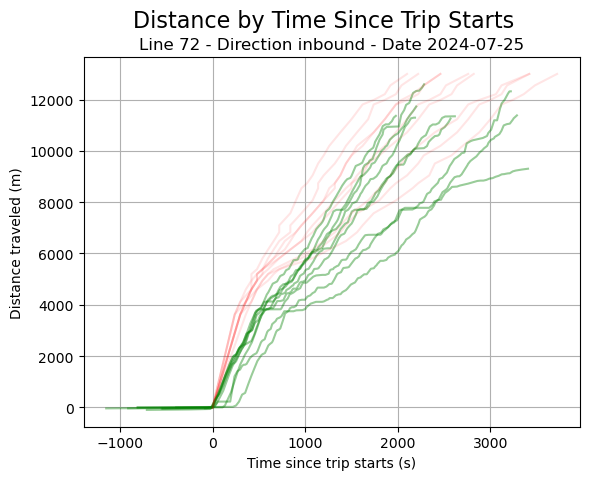

In [97]:
stats = pd.DataFrame()

t_line_data = pd.read_pickle('../data/processed/trips_matched/p_72_20240725.pkl')
direction_check = 'inbound'
# dt_cols=['RecordedAtTime','ValidUntilTime','OriginAimedDepartureTime','DestinationAimedArrivalTime']
# float_cols=['Longitude','Latitude','LongitudeMatched','LatitudeMatched','TraveledDistanceRaw','TraveledDistanceMatched','Speed']
# int_cols=['LineRef','DatedVehicleJourneyRef','BlockRef','JourneyCode','VehicleUniqueId']
# str_cols=['LineRef','DatedVehicleJourneyRef','BlockRef','EstimatedRoute','TripId']
# for col in dt_cols:
#     t_line_data[col] = pd.to_datetime(t_line_data[col])
# for col in float_cols:
#     t_line_data[col] = t_line_data[col].astype(float)
# for col in int_cols:
#     try:
#         t_line_data[col] = t_line_data[col].astype(int)
#     except:
#         continue
# for col in str_cols:
#     t_line_data[col] = t_line_data[col].astype(str)

t_trips = t_line_data['TripId'].unique().tolist()
for trip in t_trips:
    # print(f'{trip}/',end='')
    print(f'{trip}/')
    sample_trip = t_line_data[t_line_data['TripId']==trip].copy().reset_index(drop=True)
    sample_trip = sample_trip[sample_trip['DirectionRef']==direction_check]

    if sample_trip.shape[0] < 80:
        continue
    
    t_estimated_route = eval(sample_trip['EstimatedRoute'][0])
    # sample_trip = sample_trip[sample_trip['RecordedAtTime'] >= sample_trip['OriginAimedDepartureTime']]
    sample_trip['TimeCumSum'] = np.cumsum(sample_trip['TraveledTime'])
    sample_trip['DistanceCumSum'] = np.cumsum(sample_trip['TraveledDistanceMatched'])

    # Calculate Path Properties
    is_wrong_time = False
    is_diverted = False
    is_unplanned = False
    trip_type = 'Other'
    trip_line_name = sample_trip.iloc[0]['LineRef'] 

    t_timetable_data_service = (sample_trip[unique_idetifier_cols+['TripId']]
                        .head(1)
                        .merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', 
                            left_on=siri_id_cols, right_on=service_lookup_id_cols))
    t_timetable_data_path = tracking_data.loc[
        (tracking_data['RouteId']==t_timetable_data_service['RouteRef'][0]) &
        (tracking_data['LineRef']==t_timetable_data_service['LineRef'][0])
    ]
    t_timetable_data_time = timing_data.loc[
        (timing_data['JourneyPatternSectionId']==t_timetable_data_service['JourneyPatternSectionRefs'][0]) &
        (timing_data['BlockNumber'].astype(str)==t_timetable_data_service['BlockNumber'].astype(str)[0])
    ]
    t_tracking_data = t_timetable_data_path.merge(t_timetable_data_time, 'left', 
                                                left_on=['RouteLinkRef'], 
                                                right_on=['RouteLinkRef']).fillna(0)

    t_tracking_data['TimeCumSum'] = np.cumsum(t_tracking_data['RunTime'])+np.cumsum(t_tracking_data['WaitTime'])
    t_tracking_data['DistanceCumSum'] = np.cumsum(t_tracking_data['Distance'])

    merged_planned_linestring = []
    for segment in t_timetable_data_path['TrackingPoints']:
        merged_planned_linestring = merged_planned_linestring + segment
    merged_planned_linestring = LineString(merged_planned_linestring)
    actual_linestring = gpd.GeoDataFrame(geometry=[t_estimated_route], crs=4326)
    planned_linestring = gpd.GeoDataFrame(geometry=[LineString(segment) for segment in t_timetable_data_path['TrackingPoints']], crs=4326)
    raw_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(sample_trip['Longitude'], sample_trip['Latitude']), crs=4326)

    # Overrall Matching Statistics
    ## Resolution is the number of 5m segments in actual trip
    resolution = int(geod.geometry_length(actual_linestring['geometry'][0])/5)
    actual_linestring_interp = interpolate_line(actual_linestring['geometry'][0], resolution)
    distance_matching = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring_interp.coords]
    match_percentage = (len([i for i in distance_matching if i <=10]))/resolution
    # print(match_percentage)
    # print(np.mean(distance_matching))


    # Calculate Trip Adjustments
    trip_adj = sample_trip[sample_trip['RecordedAtTime'] < sample_trip['OriginAimedDepartureTime']]

    ## If the actual time is shorter than 10 minutes of the ideal timetable (very early arrival), make distance adjustments:
    first_point = sample_trip.iloc[0]
    first_500m_point = sample_trip[sample_trip['DistanceCumSum']>=500].iloc[0]
    last_point = sample_trip.iloc[-1]
    travelled_distance_pre_departure = sum(trip_adj['TraveledDistanceMatched'])
    is_correct_direction = is_points_follow_line(merged_planned_linestring,
                                                Point([first_point['LongitudeMatched'], first_point['LatitudeMatched']]),
                                                Point([first_500m_point['LongitudeMatched'], first_500m_point['LatitudeMatched']]))
    # Default value
    strat_trip_adj_time = (sample_trip['RecordedAtTime'][0] - sample_trip['OriginAimedDepartureTime'][0]).total_seconds()
    strat_trip_adj_distance = 0

    if (abs(strat_trip_adj_time) > 30*60) and (travelled_distance_pre_departure > 500):
        # Unplanned/Adhoc
        trip_type = 'Unplanned'
        is_unplanned = True
    elif is_correct_direction and (trip_adj.shape[0] > 0):
        trip_type = 'Starts Recording Early'
        # If the trip starts before expected time
        # start early --> Readjust distance
        strat_trip_adj_distance = -abs(sum(trip_adj['TraveledDistanceMatched']))
    elif is_correct_direction and (trip_adj.shape[0] <= 0):
        trip_type = 'Starts Recording Late'
        # # start late --> Interpolate
        # strat_trip_adj_distance = sum(t_tracking_data["Distance"])*t_estimated_route.project(Point([sample_trip['Longitude'][0],
        #                                                                                             sample_trip['Latitude'][0]]), normalized=True)
        strat_trip_adj_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(Point([sample_trip['Longitude'][0], 
                                                                                                                        sample_trip['Latitude'][0]]), normalized=True)
    elif ~is_correct_direction and match_percentage > 0.8:
        trip_type = 'In Unfinished Previous Trip'
        # Still in previous trip
        actual_start_point = t_estimated_route.project(Point([t_timetable_data_path.iloc[0]['TrackingPoints'][0][0],
                                                            t_timetable_data_path.iloc[0]['TrackingPoints'][0][1]]), normalized=True)
        strat_trip_adj_distance = -1*actual_start_point*geod.geometry_length(t_estimated_route)
    else:
        trip_type = 'Other'
        # Default
        strat_trip_adj_distance = 0


    sample_trip['TimeCumSumAdj'] = sample_trip['TimeCumSum'] + strat_trip_adj_time
    sample_trip['DistanceCumSumAdj'] = sample_trip['DistanceCumSum'] + strat_trip_adj_distance

    # Trip Metrics

    ## Trip Time and Distance
    planned_time = (sum(t_tracking_data["RunTime"])-sum(t_tracking_data["WaitTime"]))
    planned_distance = sum(t_tracking_data["Distance"])
    actual_time = sum(sample_trip["TraveledTime"])+strat_trip_adj_time
    actual_distance = sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance
    if (actual_time < 0) or (actual_distance < 0):
        is_wrong_time=True
        actual_time = sum(sample_trip["TraveledTime"])
        actual_distance = sum(sample_trip["TraveledDistanceMatched"])

    ## GPS errors
    gps_error_points = []
    prj_points = []
    for index, point in sample_trip.iterrows():
        raw_point = Point([point['Longitude'],point['Latitude']])
        raw_point_projection = merged_planned_linestring.project(raw_point)
        proj_raw_point_to_planned_trip = merged_planned_linestring.interpolate(raw_point_projection, normalized=False)
        distance_to_planned_route = geopy.distance.geodesic(raw_point.coords, proj_raw_point_to_planned_trip.coords).meters
        gps_error_points.append(distance_to_planned_route)
        prj_points.append(proj_raw_point_to_planned_trip)
        # print(f'\t\t{raw_point}:{proj_raw_point_to_planned_trip}-{distance_to_planned_route}')
        # print(row['c1'], row['c2'])
    # print(f'Median GPS error: {np.median(gps_error_points)}')

    ## Diversion Check
    distance_matching_diversion_check = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring['geometry'][0].coords]
    # diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 100]
    diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 50]
    diversion_data = []
    diversion_count = 0
    # diversion_check_df = pd.DataFrame()
    if len(diversion_check) > 0:
        actual_segment_count = len(actual_linestring['geometry'][0].coords)
        diversion_group = clutter_grouping(diversion_check,2,int(actual_segment_count*0.01),record_count=len(distance_matching_diversion_check)-1)
        for cluster in diversion_group:
            if cluster[0]!=cluster[1]:
                # print('DIVERSION DETECTED')
                diverted_path = LineString([actual_linestring['geometry'][0].coords[i] for i in range(cluster[0], cluster[1]+1)])
                diverted_path_length = geod.geometry_length(diverted_path)
                diversion_start_point = actual_linestring['geometry'][0].coords[cluster[0]]
                diversion_end_point = actual_linestring['geometry'][0].coords[cluster[1]]
                diversion_cluster = {
                    'diverted_path': linestring_to_string(diverted_path),
                    'diverted_path_length': diverted_path_length,
                    'diversion_start_point': diversion_start_point,
                    'diversion_end_point': diversion_end_point
                }
                # diversion_check_df = df_insert_row(diversion_check_df, diversion_cluster)
                if diverted_path_length>400:
                    diversion_count+=1
                    diversion_data.append(diversion_cluster)
    
    diversion_data = np.nan if diversion_data == [] else diversion_data

    ## Punctuation
    ### Interpolate actual data
    # actual_distance_interp = np.arange(int(list(sample_trip['DistanceCumSumAdj'])[0]), int(list(sample_trip['DistanceCumSumAdj'])[-1]), 5)
    distance_interp = np.arange(max(0, int(list(sample_trip['DistanceCumSumAdj'])[0])), 
                                min(int(list(sample_trip['DistanceCumSumAdj'])[-1]), int(list(t_tracking_data['DistanceCumSum'])[-1])), 5)
    if len(distance_interp) > 1:
        actual_time_interp = np.interp(distance_interp, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist())
        planned_time_interp = np.interp(distance_interp, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
        ## Get difference series
        ### Negative is earlier than planned and vice versa
        #### Overall Performance
        time_difference = actual_time_interp - planned_time_interp
        total_deviation = float(sum(time_difference))
        mean_deviation = float(np.mean(time_difference))
        std_deviation = float(np.std(time_difference))
        median_deviation = float(np.median(time_difference))
        max_deviation = float(max(time_difference))
        min_deviation = float(min(time_difference))
        deviation_per_km = float(sum(time_difference))/planned_distance
        #### Punctuation Performance
        percentage_ontime = sum((t <= 5*60) and (t >= -1*60) for t in time_difference)/len(time_difference)
        percentage_late = sum((t > 5*60)for t in time_difference)/len(time_difference)
        percentage_early = sum((t < -1*60) for t in time_difference)/len(time_difference)
        segment_sample_size = len(time_difference)
    else:
        time_difference = np.nan
        total_deviation = np.nan
        mean_deviation = np.nan
        std_deviation = np.nan
        median_deviation = np.nan
        max_deviation = np.nan
        min_deviation = np.nan
        deviation_per_km = np.nan
        #### Punctuation Performance
        percentage_ontime = np.nan
        percentage_late = np.nan
        percentage_early = np.nan
        segment_sample_size = len(distance_interp)

    
    btm_distance = np.nan
    bp_distance = np.nan
    bcc_distance = np.nan
    btm_time_diff = np.nan
    bp_time_diff = np.nan
    bcc_time_diff = np.nan

    if len(distance_interp) > 1:
        if trip_line_name in ['74','72']:
            btm_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_temple_meads, normalized=True)
            btm_distance_mapping = min(btm_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
            btm_time_diff = np.interp(btm_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(btm_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
        if trip_line_name in ['m4']:
            bp_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_parkway, normalized=True)
            bp_distance_mapping = min(bp_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
            bp_time_diff = np.interp(bp_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bp_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
        if trip_line_name in ['70','72','74','m1','m3','m4']:
            bcc_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_broadquay, normalized=True)
            bcc_distance_mapping = min(bcc_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
            bcc_time_diff = np.interp(bcc_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bcc_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())


    # print(prj_points)
    raw_projected_points = gpd.GeoDataFrame(geometry=prj_points, crs=4326)

    # fig = px.line(sample_trip, x=sample_trip['TimeCumSumAdj'], y=sample_trip['DistanceCumSumAdj'])
    # fig.add_scatter(x=t_tracking_data['TimeCumSum'], y=t_tracking_data['DistanceCumSum'])
    # fig.show()

    stats_update = {
        'Date': sample_trip['RecordedAtTime'][0].strftime('%Y%m%d'),
        'Hour': sample_trip['RecordedAtTime'][0].strftime('%H'),
        'TripId': trip,
        'Line': sample_trip['LineRef'][0],
        'Direction': sample_trip['DirectionRef'][0],
        'MatchedPercentage': match_percentage,
        'AverageDistance': np.mean(distance_matching),
        'MedianGpsError': np.median(gps_error_points),
        'PlannedTime': planned_time,
        'PlannedDistance': planned_distance,
        'ActualTime': actual_time,
        'ActualDistance': actual_distance,
        'TimeAdjustment': strat_trip_adj_time,
        'DistanceAdjustment': strat_trip_adj_distance,
        'TripType': trip_type,
        'IsWrongTime': is_wrong_time,
        'IsUnplanned': is_unplanned,
        # Diversion
        'IsDiverted': diversion_count>0,
        'DiversionSegmentCount': diversion_count,
        'DiversionData': diversion_data,
        # Deviation
        'TotalDeviation': total_deviation,
        'MeanDeviation': mean_deviation,
        'MedianDeviation': median_deviation,
        'StdDeviation': std_deviation,
        'MaxDeviation': max_deviation,
        'MinDeviation': min_deviation,
        'DeviationPerKm': deviation_per_km,
        'OntimePercentage': percentage_ontime,
        'LatePercentage': percentage_late,
        'EarlyPercentage': percentage_early,
        'BristolTempleMeadsTimeDiff': btm_time_diff,
        'BristolParkwayTimeDiff': bp_time_diff,
        'BristolCityCenterTimeDiff': bcc_time_diff,
        'DeviationSegmentSampleSize': segment_sample_size,
        'DeviationVector': time_difference
    }
    stats = df_insert_row(stats, stats_update)

    if strat_trip_adj_time < -2000:
        print(f'\n\t\t{matched_trip_pkl_files[4]} - {trip}')

    plt.plot('TimeCumSumAdj', 'DistanceCumSumAdj', data=sample_trip, linestyle='-', color='green', label='Actual Trip', alpha=0.4)
    plt.plot([0]+t_tracking_data['TimeCumSum'].tolist(), [0]+t_tracking_data['DistanceCumSum'].tolist(), linestyle='-', color='red', label='Planned Trip', alpha=0.1)
    # plt.plot(distance_interp, time_difference, linestyle='-', color='orange', label='Actual Trip')
    # plt.xlim(0,15000)
    # plt.ylim(-500,1500)



# # fig,ax = plt.subplots(1)
# plt.figure(figsize=(8, 6))

plt.suptitle('Distance by Time Since Trip Starts', fontsize=16)
plt.title(f"Line {sample_trip.loc[0]['LineRef']} - Direction {direction_check} - Date {sample_trip.loc[0]['DataFrameRef']}")
plt.grid(True)
plt.xlabel('Time since trip starts (s)')
plt.ylabel('Distance traveled (m)')

# # plt.plot(actual_time_interp, distance_interp, color='green',  label='Actual Trip')
# # # plt.plot(planned_time_interp, distance_interp, color='red',  label='Planned Trip')
# # plt.plot('TimeCumSumAdj', 'DistanceCumSumAdj', data=sample_trip, linestyle='-', color='green', label='Actual Trip')
# # plt.plot([0]+t_tracking_data['TimeCumSum'].tolist(), [0]+t_tracking_data['DistanceCumSum'].tolist(), linestyle='-', color='red', label='Planned Trip')

# plt.legend(title='Trip Type',
#            loc=2)
# plt.axhline(1,color='red')
plt.grid(True)
plt.show()

In [ ]:
stats

# Mass Processing

In [ ]:
stats = pd.DataFrame()
for pkl_file in matched_trip_pkl_files:
    t_line_data = pd.read_pickle(pkl_file)
    t_trips = t_line_data['TripId'].unique().tolist()
    
    for trip in t_trips:
        # print(f'{trip}/',end='')
        print(f'{pkl_file}/{trip}/')
        sample_trip = t_line_data[t_line_data['TripId']==trip].reset_index(drop=True)
        if sample_trip.shape[0] < 80:
            continue

        t_estimated_route = eval(sample_trip['EstimatedRoute'][0])
        # sample_trip = sample_trip[sample_trip['RecordedAtTime'] >= sample_trip['OriginAimedDepartureTime']]
        sample_trip['TimeCumSum'] = np.cumsum(sample_trip['TraveledTime'])
        sample_trip['DistanceCumSum'] = np.cumsum(sample_trip['TraveledDistanceMatched'])

        # Calculate Path Properties
        is_wrong_time = False
        is_diverted = False
        is_unplanned = False
        trip_type = 'Other'
        trip_line_name = sample_trip.iloc[0]['LineRef'] 

        t_timetable_data_service = (sample_trip[unique_idetifier_cols+['TripId']]
                            .head(1)
                            .merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', 
                                left_on=siri_id_cols, right_on=service_lookup_id_cols))
        t_timetable_data_path = tracking_data.loc[
            (tracking_data['RouteId']==t_timetable_data_service['RouteRef'][0]) &
            (tracking_data['LineRef']==t_timetable_data_service['LineRef'][0])
        ]
        t_timetable_data_time = timing_data.loc[
            (timing_data['JourneyPatternSectionId']==t_timetable_data_service['JourneyPatternSectionRefs'][0]) &
            (timing_data['BlockNumber'].astype(str)==t_timetable_data_service['BlockNumber'].astype(str)[0])
        ]
        t_tracking_data = t_timetable_data_path.merge(t_timetable_data_time, 'left', 
                                                    left_on=['RouteLinkRef'], 
                                                    right_on=['RouteLinkRef']).fillna(0)

        t_tracking_data['TimeCumSum'] = np.cumsum(t_tracking_data['RunTime'])+np.cumsum(t_tracking_data['WaitTime'])
        t_tracking_data['DistanceCumSum'] = np.cumsum(t_tracking_data['Distance'])

        merged_planned_linestring = []
        for segment in t_timetable_data_path['TrackingPoints']:
            merged_planned_linestring = merged_planned_linestring + segment
        merged_planned_linestring = LineString(merged_planned_linestring)
        actual_linestring = gpd.GeoDataFrame(geometry=[t_estimated_route], crs=4326)
        planned_linestring = gpd.GeoDataFrame(geometry=[LineString(segment) for segment in t_timetable_data_path['TrackingPoints']], crs=4326)
        raw_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(sample_trip['Longitude'], sample_trip['Latitude']), crs=4326)

        # Overrall Matching Statistics
        ## Resolution is the number of 5m segments in actual trip
        resolution = int(geod.geometry_length(actual_linestring['geometry'][0])/5)
        actual_linestring_interp = interpolate_line(actual_linestring['geometry'][0], resolution)
        distance_matching = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring_interp.coords]
        match_percentage = (len([i for i in distance_matching if i <=10]))/resolution
        # print(match_percentage)
        # print(np.mean(distance_matching))


        # Calculate Trip Adjustments
        trip_adj = sample_trip[sample_trip['RecordedAtTime'] < sample_trip['OriginAimedDepartureTime']]

        ## If the actual time is shorter than 10 minutes of the ideal timetable (very early arrival), make distance adjustments:
        first_point = sample_trip.iloc[0]
        first_500m_point = sample_trip[sample_trip['DistanceCumSum']>=500].iloc[0]
        last_point = sample_trip.iloc[-1]
        travelled_distance_pre_departure = sum(trip_adj['TraveledDistanceMatched'])
        is_correct_direction = is_points_follow_line(merged_planned_linestring,
                                                    Point([first_point['LongitudeMatched'], first_point['LatitudeMatched']]),
                                                    Point([first_500m_point['LongitudeMatched'], first_500m_point['LatitudeMatched']]))
        # Default value
        strat_trip_adj_time = (sample_trip['RecordedAtTime'][0] - sample_trip['OriginAimedDepartureTime'][0]).total_seconds()
        strat_trip_adj_distance = 0

        if (abs(strat_trip_adj_time) > 30*60) and (travelled_distance_pre_departure > 500):
            # Unplanned/Adhoc
            trip_type = 'Unplanned'
            is_unplanned = True
        elif is_correct_direction and (trip_adj.shape[0] > 0):
            trip_type = 'Starts Recording Early'
            # If the trip starts before expected time
            # start early --> Readjust distance
            strat_trip_adj_distance = -abs(sum(trip_adj['TraveledDistanceMatched']))
        elif is_correct_direction and (trip_adj.shape[0] <= 0):
            trip_type = 'Starts Recording Late'
            # # start late --> Interpolate
            # strat_trip_adj_distance = sum(t_tracking_data["Distance"])*t_estimated_route.project(Point([sample_trip['Longitude'][0],
            #                                                                                             sample_trip['Latitude'][0]]), normalized=True)
            strat_trip_adj_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(Point([sample_trip['Longitude'][0], 
                                                                                                                            sample_trip['Latitude'][0]]), normalized=True)
        elif ~is_correct_direction and match_percentage > 0.8:
            trip_type = 'In Unfinished Previous Trip'
            # Still in previous trip
            actual_start_point = t_estimated_route.project(Point([t_timetable_data_path.iloc[0]['TrackingPoints'][0][0],
                                                                t_timetable_data_path.iloc[0]['TrackingPoints'][0][1]]), normalized=True)
            strat_trip_adj_distance = -1*actual_start_point*geod.geometry_length(t_estimated_route)
        else:
            trip_type = 'Other'
            # Default
            strat_trip_adj_distance = 0


        sample_trip['TimeCumSumAdj'] = sample_trip['TimeCumSum'] + strat_trip_adj_time
        sample_trip['DistanceCumSumAdj'] = sample_trip['DistanceCumSum'] + strat_trip_adj_distance

        # Trip Metrics

        ## Trip Time and Distance
        planned_time = (sum(t_tracking_data["RunTime"])-sum(t_tracking_data["WaitTime"]))
        planned_distance = sum(t_tracking_data["Distance"])
        actual_time = sum(sample_trip["TraveledTime"])+strat_trip_adj_time
        actual_distance = sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance
        if (actual_time < 0) or (actual_distance < 0):
            is_wrong_time=True
            actual_time = sum(sample_trip["TraveledTime"])
            actual_distance = sum(sample_trip["TraveledDistanceMatched"])

        ## GPS errors
        gps_error_points = []
        prj_points = []
        for index, point in sample_trip.iterrows():
            raw_point = Point([point['Longitude'],point['Latitude']])
            raw_point_projection = merged_planned_linestring.project(raw_point)
            proj_raw_point_to_planned_trip = merged_planned_linestring.interpolate(raw_point_projection, normalized=False)
            distance_to_planned_route = geopy.distance.geodesic(raw_point.coords, proj_raw_point_to_planned_trip.coords).meters
            gps_error_points.append(distance_to_planned_route)
            prj_points.append(proj_raw_point_to_planned_trip)
            # print(f'\t\t{raw_point}:{proj_raw_point_to_planned_trip}-{distance_to_planned_route}')
            # print(row['c1'], row['c2'])
        # print(f'Median GPS error: {np.median(gps_error_points)}')

        ## Diversion Check
        distance_matching_diversion_check = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring['geometry'][0].coords]
        # diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 100]
        diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 50]
        diversion_data = []
        diversion_count = 0
        # diversion_check_df = pd.DataFrame()
        if len(diversion_check) > 0:
            actual_segment_count = len(actual_linestring['geometry'][0].coords)
            diversion_group = clutter_grouping(diversion_check,2,int(actual_segment_count*0.01),record_count=len(distance_matching_diversion_check)-1)
            for cluster in diversion_group:
                if cluster[0]!=cluster[1]:
                    # print('DIVERSION DETECTED')
                    diverted_path = LineString([actual_linestring['geometry'][0].coords[i] for i in range(cluster[0], cluster[1]+1)])
                    diverted_path_length = geod.geometry_length(diverted_path)
                    diversion_start_point = actual_linestring['geometry'][0].coords[cluster[0]]
                    diversion_end_point = actual_linestring['geometry'][0].coords[cluster[1]]
                    diversion_cluster = {
                        'diverted_path': linestring_to_string(diverted_path),
                        'diverted_path_length': diverted_path_length,
                        'diversion_start_point': diversion_start_point,
                        'diversion_end_point': diversion_end_point
                    }
                    # diversion_check_df = df_insert_row(diversion_check_df, diversion_cluster)
                    if diverted_path_length>400:
                        diversion_count+=1
                        diversion_data.append(diversion_cluster)
        
        diversion_data = np.nan if diversion_data == [] else diversion_data

        ## Punctuation
        ### Interpolate actual data
        # actual_distance_interp = np.arange(int(list(sample_trip['DistanceCumSumAdj'])[0]), int(list(sample_trip['DistanceCumSumAdj'])[-1]), 5)
        distance_interp = np.arange(max(0, int(list(sample_trip['DistanceCumSumAdj'])[0])), 
                                    min(int(list(sample_trip['DistanceCumSumAdj'])[-1]), int(list(t_tracking_data['DistanceCumSum'])[-1])), 5)
        if len(distance_interp) > 1:
            actual_time_interp = np.interp(distance_interp, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist())
            planned_time_interp = np.interp(distance_interp, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            ## Get difference series
            ### Negative is earlier than planned and vice versa
            #### Overall Performance
            time_difference = actual_time_interp - planned_time_interp
            total_deviation = float(sum(time_difference))
            mean_deviation = float(np.mean(time_difference))
            std_deviation = float(np.std(time_difference))
            median_deviation = float(np.median(time_difference))
            max_deviation = float(max(time_difference))
            min_deviation = float(min(time_difference))
            deviation_per_km = float(sum(time_difference))/planned_distance
            #### Punctuation Performance
            percentage_ontime = sum((t <= 5*60) and (t >= -1*60) for t in time_difference)/len(time_difference)
            percentage_late = sum((t > 5*60)for t in time_difference)/len(time_difference)
            percentage_early = sum((t < -1*60) for t in time_difference)/len(time_difference)
            segment_sample_size = len(time_difference)
        else:
            time_difference = np.nan
            total_deviation = np.nan
            mean_deviation = np.nan
            std_deviation = np.nan
            median_deviation = np.nan
            max_deviation = np.nan
            min_deviation = np.nan
            deviation_per_km = np.nan
            #### Punctuation Performance
            percentage_ontime = np.nan
            percentage_late = np.nan
            percentage_early = np.nan
            segment_sample_size = len(distance_interp)

        
        btm_distance = np.nan
        bp_distance = np.nan
        bcc_distance = np.nan
        btm_time_diff = np.nan
        bp_time_diff = np.nan
        bcc_time_diff = np.nan

        if len(distance_interp) > 1:
            if trip_line_name in ['74','72']:
                btm_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_temple_meads, normalized=True)
                btm_distance_mapping = min(btm_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                btm_time_diff = np.interp(btm_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(btm_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            if trip_line_name in ['m4']:
                bp_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_parkway, normalized=True)
                bp_distance_mapping = min(bp_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                bp_time_diff = np.interp(bp_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bp_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            if trip_line_name in ['70','72','74','m1','m3','m4']:
                bcc_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_broadquay, normalized=True)
                bcc_distance_mapping = min(bcc_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                bcc_time_diff = np.interp(bcc_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bcc_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())


        # print(prj_points)
        raw_projected_points = gpd.GeoDataFrame(geometry=prj_points, crs=4326)

        # fig = px.line(sample_trip, x=sample_trip['TimeCumSumAdj'], y=sample_trip['DistanceCumSumAdj'])
        # fig.add_scatter(x=t_tracking_data['TimeCumSum'], y=t_tracking_data['DistanceCumSum'])
        # fig.show()

        stats_update = {
            'Date': sample_trip['RecordedAtTime'][0].strftime('%Y%m%d'),
            'Hour': sample_trip['RecordedAtTime'][0].strftime('%H'),
            'TripId': trip,
            'Line': sample_trip['LineRef'][0],
            'Direction': sample_trip['DirectionRef'][0],
            'MatchedPercentage': match_percentage,
            'AverageDistance': np.mean(distance_matching),
            'MedianGpsError': np.median(gps_error_points),
            'PlannedTime': planned_time,
            'PlannedDistance': planned_distance,
            'ActualTime': actual_time,
            'ActualDistance': actual_distance,
            'TimeAdjustment': strat_trip_adj_time,
            'DistanceAdjustment': strat_trip_adj_distance,
            'TripType': trip_type,
            'IsWrongTime': is_wrong_time,
            'IsUnplanned': is_unplanned,
            # Diversion
            'IsDiverted': diversion_count>0,
            'DiversionSegmentCount': diversion_count,
            'DiversionData': diversion_data,
            # Deviation
            'TotalDeviation': total_deviation,
            'MeanDeviation': mean_deviation,
            'MedianDeviation': median_deviation,
            'StdDeviation': std_deviation,
            'MaxDeviation': max_deviation,
            'MinDeviation': min_deviation,
            'DeviationPerKm': deviation_per_km,
            'OntimePercentage': percentage_ontime,
            'LatePercentage': percentage_late,
            'EarlyPercentage': percentage_early,
            'BristolTempleMeadsTimeDiff': btm_time_diff,
            'BristolParkwayTimeDiff': bp_time_diff,
            'BristolCityCenterTimeDiff': bcc_time_diff,
            'DeviationSegmentSampleSize': segment_sample_size,
            'DeviationVector': time_difference
        }
        stats = df_insert_row(stats, stats_update)

# plt.show()

In [ ]:
stats.to_csv('../data/processed/stats.csv')
stats.to_pickle('../data/processed/stats.pkl')

In [ ]:
stats

## Analyzing the stats

In [ ]:
print(f"Mean of median GPS error per trip {np.mean(stats[stats['MatchedPercentage']>=0.95]['MedianGpsError'])}")
print(f"Number of trips with diverted route registered {(stats['IsDiverted']==True).sum()} ({(stats['IsDiverted']==True).sum()/stats.shape[0]})")

# Speed Processing

### Base Data

In [ ]:
speed_data = pd.DataFrame()
# date, time, line, lat, long, speed, hex_code, hex_level, record_count
for file in matched_trip_pkl_files:
    print(f'PROCESSING {file}')
    t_line_data = pd.read_pickle(file)
    t_speed_data = pd.DataFrame()
    t_line_data = t_line_data.loc[
        (~t_line_data['LastTimestamp'].isna())
    ]
    # for col in dt_cols:
    #     t_line_data[col] = pd.to_datetime(t_line_data[col])
    # for col in float_cols:
    #     t_line_data[col] = t_line_data[col].astype(float)
    # for col in int_cols:
    #     try:
    #         t_line_data[col] = t_line_data[col].astype(int)
    #     except:
    #         continue
    # for col in str_cols:
    #     t_line_data[col] = t_line_data[col].astype(str)

    t_speed_data['date'] = t_line_data['RecordedAtTime'].apply(lambda x: x.strftime('%Y%m%d'))
    t_speed_data['hour'] = t_line_data['RecordedAtTime'].apply(lambda x: x.strftime('%H'))
    t_speed_data['line'] = t_line_data['LineRef']
    t_speed_data['lon'] = t_line_data['LongitudeMatched']
    t_speed_data['lat'] = t_line_data['LatitudeMatched']
    t_speed_data['speed'] = t_line_data['Speed']
    # t_speed_data['hex_code'] = t_speed_data.apply(lambda x: h3.geo_to_h3(lat=x['lat'],lng=x['lon'],resolution=hex_res))
    # t_speed_data['hex_res'] = hex_res
    t_speed_data.reset_index(drop=True, inplace=True)
    speed_data = pd.concat([speed_data, t_speed_data],ignore_index=True)



In [ ]:
speed_data

### Test Data

In [ ]:
test_files = [i for i in matched_trip_pkl_files if '20240725' in i]

st = 15

start_sampling_time = str(st).zfill(2)+':00:00'
end_sampling_time = str(st+2).zfill(2)+':00:00'

local_speed_data = pd.DataFrame()
# date, time, line, lat, long, speed, hex_code, hex_level, record_count
for file in test_files:
    print(f'PROCESSING {file}')
    t_line_data = pd.read_pickle(file)
    t_speed_data = pd.DataFrame()
    t_line_data = t_line_data.loc[
        (~t_line_data['LastTimestamp'].isna())
    ]
    t_line_data = t_line_data.loc[
        (t_line_data['RecordedAtTime'].dt.time >= pd.Timestamp(start_sampling_time).time()) &
        (t_line_data['RecordedAtTime'].dt.time <= pd.Timestamp(end_sampling_time).time())
    ]
    # for col in dt_cols:
    #     t_line_data[col] = pd.to_datetime(t_line_data[col])
    # for col in float_cols:
    #     t_line_data[col] = t_line_data[col].astype(float)
    # for col in int_cols:
    #     try:
    #         t_line_data[col] = t_line_data[col].astype(int)
    #     except:
    #         continue
    # for col in str_cols:
    #     t_line_data[col] = t_line_data[col].astype(str)

    t_speed_data['date'] = t_line_data['RecordedAtTime'].apply(lambda x: x.strftime('%Y%m%d'))
    t_speed_data['hour'] = t_line_data['RecordedAtTime'].apply(lambda x: x.strftime('%H'))
    t_speed_data['line'] = t_line_data['LineRef']
    t_speed_data['lon'] = t_line_data['LongitudeMatched']
    t_speed_data['lat'] = t_line_data['LatitudeMatched']
    t_speed_data['speed'] = t_line_data['Speed']
    # t_speed_data['hex_code'] = t_speed_data.apply(lambda x: h3.geo_to_h3(lat=x['lat'],lng=x['lon'],resolution=hex_res))
    # t_speed_data['hex_res'] = hex_res
    t_speed_data.reset_index(drop=True, inplace=True)
    local_speed_data = pd.concat([local_speed_data, t_speed_data],ignore_index=True)

### Visualisation

In [ ]:
def hexagons_dataframe_to_geojson(df_hex, file_output = None, column_name = "value"):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and with a property matching the one in column_name
    """    
    list_features = []
    
    for i,row in df_hex.iterrows():
        try:
            geometry_for_row = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row["hex_code"],geo_json=True)]}
            feature = Feature(geometry = geometry_for_row , id=row["hex_code"], properties = {column_name : row[column_name]})
            list_features.append(feature)
        except:
            print("An exception occurred for hex " + row["hex_code"]) 

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result

def get_color(custom_cm, val, vmin, vmax):
    return matplotlib.colors.to_hex(custom_cm((val-vmin)/(vmax-vmin)))

def choropleth_map(df_aggreg, column_name = "value", border_color = 'black', fill_opacity = 0.7, color_map_name = "viridis", initial_map = None):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.
    """    
    #colormap
    min_value = df_aggreg[column_name].min()
    max_value = df_aggreg[column_name].max()
    mean_value = df_aggreg[column_name].mean()
    print(f"Colour column min value {min_value}, max value {max_value}, mean value {mean_value}")
    print(f"Hexagon cell count: {df_aggreg['hex_code'].nunique()}")
    
    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "Choropleth " + str(df_aggreg)
    
    if initial_map is None:
        initial_map = folium.Map([51.49856419519174, -2.548053188420676], tiles='cartodbdark_matter', zoom_start=12)

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg, column_name = column_name)

    # color_map_name 'Blues' for now, many more at https://matplotlib.org/stable/tutorials/colors/colormaps.html to choose from!
    custom_cm = matplotlib.cm.get_cmap(color_map_name)

    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            # 'fillColor' : 'virdis',
            # 'color': border_color,
            'weight': 0,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    return initial_map

In [ ]:
hex_res = 10

# Base data
geoindexed_speed_data = speed_data.copy()
geoindexed_speed_data['hex_code'] = geoindexed_speed_data.apply(lambda x: h3.geo_to_h3(lat=x['lat'],lng=x['lon'],resolution=hex_res), axis=1)
geoindexed_speed_data['hex_res'] = hex_res

hex_data = geoindexed_speed_data[geoindexed_speed_data['speed'] <= bus_speed_limit]
hex_data = hex_data.groupby(['hex_code'], as_index=False).agg(
    base_speed = ('speed', 'median'),
    std_speed = ('speed', 'std'),
    var_speed = ('speed', 'var')
)

# Local data
local_geoindexed_speed_data = local_speed_data.copy()
local_geoindexed_speed_data['hex_code'] = local_geoindexed_speed_data.apply(lambda x: h3.geo_to_h3(lat=x['lat'],lng=x['lon'],resolution=hex_res), axis=1)
local_geoindexed_speed_data['hex_res'] = hex_res

local_hex_data = local_geoindexed_speed_data[local_geoindexed_speed_data['speed'] <= bus_speed_limit]
local_hex_data = local_hex_data.groupby(['hex_code'], as_index=False).agg(
    local_speed = ('speed', 'median')
)

gap_data = local_hex_data.merge(hex_data,'left',on='hex_code')
# Base - Local -> positive: current speed is slower than anticipation
gap_data['gap'] = gap_data['base_speed'] - gap_data['local_speed']
gap_data = gap_data[gap_data['gap'] > gap_data['std_speed']]

# choropleth_map(local_hex_data, 'local_speed')
# choropleth_map(hex_data, 'base_speed')
choropleth_map(gap_data, 'gap', color_map_name='Blues')


# Statistical Analysis

In [ ]:
t_line_data = pd.read_pickle(matched_trip_pkl_files[4])
# dt_cols=['RecordedAtTime','ValidUntilTime','OriginAimedDepartureTime','DestinationAimedArrivalTime']
# float_cols=['Longitude','Latitude','LongitudeMatched','LatitudeMatched','TraveledDistanceRaw','TraveledDistanceMatched','Speed']
# int_cols=['LineRef','DatedVehicleJourneyRef','BlockRef','JourneyCode','VehicleUniqueId']
# str_cols=['LineRef','DatedVehicleJourneyRef','BlockRef','EstimatedRoute','TripId']
# for col in dt_cols:
#     t_line_data[col] = pd.to_datetime(t_line_data[col])
# for col in float_cols:
#     t_line_data[col] = t_line_data[col].astype(float)
# for col in int_cols:
#     try:
#         t_line_data[col] = t_line_data[col].astype(int)
#     except:
#         continue
# for col in str_cols:
#     t_line_data[col] = t_line_data[col].astype(str)

t_trips = t_line_data['TripId'].unique().tolist()
for trip in t_trips:
    print(f'{trip}/',end='')
    sample_trip = t_line_data[t_line_data['TripId']==trip].copy().reset_index(drop=True)
    t_estimated_route = eval(sample_trip['EstimatedRoute'][0])
    # sample_trip = sample_trip[sample_trip['RecordedAtTime'] >= sample_trip['OriginAimedDepartureTime']]
    sample_trip['TimeCumSum'] = np.cumsum(sample_trip['TraveledTime'])
    sample_trip['DistanceCumSum'] = np.cumsum(sample_trip['TraveledDistanceMatched'])

    t_timetable_data_service = (sample_trip[unique_idetifier_cols+['TripId']]
                    .head(1)
                    .merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', 
                           left_on=siri_id_cols, right_on=service_lookup_id_cols))
    t_timetable_data_path = tracking_data.loc[(tracking_data['RouteId']==t_timetable_data_service['RouteRef'][0]) & (tracking_data['LineRef']==t_timetable_data_service['LineRef'][0])]
    t_timetable_data_time = timing_data.loc[(timing_data['JourneyPatternSectionId']==t_timetable_data_service['JourneyPatternSectionRefs'][0]) &(timing_data['BlockNumber'].astype(str)==t_timetable_data_service['BlockNumber'].astype(str)[0])]

    t_tracking_data = t_timetable_data_path.merge(t_timetable_data_time, 'left', 
                                                  left_on=['RouteLinkRef'], 
                                                  right_on=['RouteLinkRef']).fillna(0)

    t_tracking_data['TimeCumSum'] = np.cumsum(t_tracking_data['RunTime'])+np.cumsum(t_tracking_data['WaitTime'])
    t_tracking_data['DistanceCumSum'] = np.cumsum(t_tracking_data['Distance'])

    strat_trip_adj_time = 0
    strat_trip_adj_distance = 0

    # If the actual time is shorter than 10 minutes of the ideal timetable (very early arrival), make distance adjustments:
    trip_adj = sample_trip[sample_trip['RecordedAtTime'] < sample_trip['OriginAimedDepartureTime']]

    if trip_adj.shape[0] > 0:
        # If the trip starts before expected time
        strat_trip_adj_time = -abs((sample_trip['RecordedAtTime'][0] - sample_trip['OriginAimedDepartureTime'][0]).total_seconds())
        strat_trip_adj_distance = -abs(sum(trip_adj['TraveledDistanceMatched']))
    else:
        # If start early --> Readjust distance
        # If start late --> Interpolate
        strat_trip_adj_time = abs((sample_trip['RecordedAtTime'][0] - sample_trip['OriginAimedDepartureTime'][0]).total_seconds())
        strat_trip_adj = t_tracking_data.loc[(t_tracking_data['TimeCumSum']<=strat_trip_adj_time)]
        interpolation_index = strat_trip_adj.shape[0]
        strat_trip_adj_time_interpolation = strat_trip_adj_time - sum(strat_trip_adj['RunTime']) - sum(strat_trip_adj['WaitTime'])
        strat_trip_adj_distance = sum(strat_trip_adj['Distance']) + t_tracking_data['Distance'][interpolation_index]*(strat_trip_adj_time_interpolation/t_tracking_data['RunTime'][interpolation_index])

    planned_time = (sum(t_tracking_data["RunTime"])-sum(t_tracking_data["WaitTime"]))
    actual_time = sum(sample_trip["TraveledTime"])+strat_trip_adj_time
    planned_distance = sum(t_tracking_data["Distance"])
    actual_distance = sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance

    sample_trip['TimeCumSumAdj'] = sample_trip['TimeCumSum'] + strat_trip_adj_time
    sample_trip['DistanceCumSumAdj'] = sample_trip['DistanceCumSum'] + strat_trip_adj_distance

    merged_planned_linestring = ops.linemerge(MultiLineString([LineString(eval(segment)) for segment in t_timetable_data_path['TrackingPoints']]))
    actual_linestring = gpd.GeoDataFrame(geometry=[t_estimated_route], crs=4326)
    planned_linestring = gpd.GeoDataFrame(geometry=[merged_planned_linestring], crs=4326)
    raw_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(sample_trip['Longitude'], sample_trip['Latitude']), crs=4326)

    gps_error_points = []
    prj_points = []
    for index, point in sample_trip.iterrows():
        raw_point = Point([point['Longitude'],point['Latitude']])
        raw_point_projection = merged_planned_linestring.project(raw_point)
        proj_raw_point_to_planned_trip = merged_planned_linestring.interpolate(raw_point_projection, normalized=False)
        distance_to_planned_route = geopy.distance.geodesic(raw_point.coords, proj_raw_point_to_planned_trip.coords).meters
        gps_error_points.append(distance_to_planned_route)
        prj_points.append(proj_raw_point_to_planned_trip)

    raw_projected_points = gpd.GeoDataFrame(geometry=prj_points, crs=4326)

    starting_data = pd.DataFrame({'time':[0, t_tracking_data['TimeCumSum'][0]],
                                'distance':[0, t_tracking_data['DistanceCumSum'][0]]})

    print(f'{planned_time}/{actual_time}/{actual_distance-planned_distance}/{actual_distance}/{np.median(gps_error_points)}')

#     plt.plot('TimeCumSumAdj', 'DistanceCumSumAdj', data=sample_trip, linestyle='-', color='green')
#     plt.plot('TimeCumSum', 'DistanceCumSum', data=t_tracking_data, linestyle='-', color='red')
#     plt.plot('time', 'distance', data=starting_data, linestyle='-', color='red')

# plt.show()

In [ ]:
print(f'Planned Path Distance: {sum(t_tracking_data["Distance"])}')
print(f'Planned Path Time: {planned_time}')
print(f'Actual Path Distance: {sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance}')
print(f'Actual Path Time: {actual_time}')

#%% RAW & MAP-MATCHING ROUTES - DRAW MAP
m = folium.Map([51.49856419519174, -2.548053188420676], tiles='cartodbdark_matter', zoom_start=14)
# m = folium.Map([51.49856419519174, -2.548053188420676], tiles='OpenStreetMap', zoom_start=14)
# folium.GeoJson(before_all, style_function=lambda x:{'color': 'red'}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='red', fill_opacity=1), name='rawGPS_points').add_to(m)
# folium.GeoJson(after_points, marker=folium.CircleMarker(radius=4, weight=0, fill_color='white', fill_opacity=1), name='snapped_points').add_to(m)
# folium.GeoJson(estimated_route, style_function=lambda x:{'color': 'green'}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='green', fill_opacity=1), name='estimated_route').add_to(m)
# folium.GeoJson(after_all, style_function=lambda x:{'color': 'green'}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='green', fill_opacity=1), name='estimated_route').add_to(m)

folium.GeoJson(planned_linestring, style_function=lambda x:{'color': 'red', 'opacity': 0.75}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='green', fill_opacity=1), name='planned_path').add_to(m)
folium.GeoJson(actual_linestring, style_function=lambda x:{'color': 'green', 'opacity': 0.75}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='blue', fill_opacity=0.5), name='actual_path').add_to(m)
# folium.GeoJson(before_d_all, style_function=lambda x:{'color': 'red'}, marker=folium.CircleMarker(radius=4, weight=0, fill_color='red', fill_opacity=1), name='rawGPS_points_decluttered').add_to(m)
folium.GeoJson(raw_points, marker=folium.CircleMarker(radius=4, weight=0, fill_color='white', fill_opacity=1), name='raw_points').add_to(m)
folium.GeoJson(raw_projected_points, marker=folium.CircleMarker(radius=4, weight=0, fill_color='red', fill_opacity=1), name='raw_projected_points').add_to(m)


folium.CircleMarker(location=actual_linestring['geometry'][0].coords[0][::-1],
                        radius=10,
                        color='green',
                        weight=5).add_to(m)

# folium.CircleMarker(location=planned_linestring['geometry'][0].coords[0][::-1],
#                         radius=10,
#                         color='red',
#                         weight=5).add_to(m)

# folium.CircleMarker(location=actual_linestring['geometry'][0].coords[5][::-1],
#                         radius=10,
#                         color='orange',
#                         weight=5).add_to(m)

folium.LayerControl(position='topright', collapsed=False).add_to(m)
# m.save('mapmatching.html')
m